In [1]:
from tensorflow.keras import layers, models, Model, Input
import pandas as pd
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from numpy import asarray
from sklearn import model_selection, metrics
import seaborn as sns
from sklearn.model_selection import ShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
labels = pd.read_csv('codes_categorized.csv', index_col = 'id')
labels.head(5)
results_folder = "results/updated_model/"
labels.head(5)

C:\Users\humdi\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
for (columnName, columnData) in labels.iteritems():
    print(labels[columnName].value_counts(normalize=True) * 100)
    print(labels[columnName].value_counts())

2.0    75.000
0.0    21.875
1.0     3.125
Name: oxygen_regulation, dtype: float64
2.0    48
0.0    14
1.0     2
Name: oxygen_regulation, dtype: int64
2.0    53.1250
0.0    32.8125
1.0    14.0625
Name: radiation_protection, dtype: float64
2.0    34
0.0    21
1.0     9
Name: radiation_protection, dtype: int64
1    54.6875
0    45.3125
Name: gravity, dtype: float64
1    35
0    29
Name: gravity, dtype: int64
1.0    54.6875
2.0    23.4375
0.0    21.8750
Name: food, dtype: float64
1.0    35
2.0    15
0.0    14
Name: food, dtype: int64
2.0    59.375
0.0    34.375
1.0     6.250
Name: supplies, dtype: float64
2.0    38
0.0    22
1.0     4
Name: supplies, dtype: int64
2.0    60.9375
0.0    31.2500
1.0     7.8125
Name: power_generation, dtype: float64
2.0    39
0.0    20
1.0     5
Name: power_generation, dtype: int64
0    65.625
1    34.375
Name: health, dtype: float64
0    42
1    22
Name: health, dtype: int64
2.0    64.0625
0.0    32.8125
1.0     3.1250
Name: communications_facilities, dtype: 

In [5]:
def loadCategorical():
    categorical = pd.read_csv('block_counts_normalized_updated.csv', index_col = "id")
    return categorical

In [7]:
categorical = loadCategorical()
categorical

,minecraft:gray_stained_glass,minecraft:quartz_block,minecraft:quartz_slab,minecraft:quartz_stairs,minecraft:gray_carpet,minecraft:red_carpet,minecraft:iron_bars,minecraft:green_glazed_terracotta,minecraft:polished_andesite,minecraft:polished_andesite_stairs,...,minecraft:cherry_stairs,minecraft:cherry_fence,minecraft:cherry_pressure_plate,minecraft:cherry_sapling,minecraft:cherry_log,minecraft:cherry_leaves,minecraft:cherry_wall_hanging_sign,minecraft:cherry_wall_sign,minecraft:spruce_wall_hanging_sign,minecraft:flower_banner_pattern
id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.000000,0.000000,0.025316,0.434211,0.000000,0.382766,0.0,0.049939,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.000000,0.254671,0.000000,0.036568,0.000000,0.000000,0.096192,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.000000,0.002950,0.144432,0.392405,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.220256,1.000000,0.026723,0.000000,0.000000,0.627255,0.0,0.014616,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.000000,0.000000,0.115766,0.078762,0.000000,0.000000,0.238477,0.0,0.025274,0.028269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.002950,0.059537,0.127989,0.039474,0.175084,0.154309,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.000000,0.015436,0.075949,0.000000,0.000000,0.146293,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.000000,0.109151,0.000000,1.000000,0.000000,0.188377,0.0,0.000609,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058824


In [5]:
def loadImages():
    train_images_aerial = [None] * len(labels.index)
    train_images_below = [None] * len(labels.index)
    directory = os.path.join(os.getcwd(),'images')
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            extension = filename.find('.')
            prefix = filename[:extension]
            image_num = ""
            for i in prefix: 
                if i.isdigit():
                    image_num += str(i)
            image_num = int(image_num) - 1
            print("Image " + str(image_num) + " has been loaded")
            image = Image.open(f)
            image = image.resize((128,128))
            pic = asarray(image)
            # convert from integers to floats
            pic = pic.astype('float32')
            # normalize to the range 0-1
            pic /= 255.0
            if prefix.__contains__('a'):
                train_images_aerial[image_num] = pic
            else:
                train_images_below[image_num] = pic
    return (train_images_aerial, train_images_below)
        

Image 9 has been loaded
Image 9 has been loaded
Image 10 has been loaded
Image 10 has been loaded
Image 11 has been loaded
Image 11 has been loaded
Image 12 has been loaded
Image 12 has been loaded
Image 13 has been loaded
Image 13 has been loaded
Image 14 has been loaded
Image 14 has been loaded
Image 15 has been loaded
Image 15 has been loaded
Image 16 has been loaded
Image 16 has been loaded
Image 17 has been loaded
Image 17 has been loaded
Image 18 has been loaded
Image 18 has been loaded
Image 0 has been loaded
Image 0 has been loaded
Image 19 has been loaded
Image 19 has been loaded
Image 20 has been loaded
Image 20 has been loaded
Image 1 has been loaded
Image 1 has been loaded
Image 2 has been loaded
Image 2 has been loaded
Image 3 has been loaded
Image 3 has been loaded
Image 4 has been loaded
Image 4 has been loaded
Image 5 has been loaded
Image 5 has been loaded
Image 6 has been loaded
Image 6 has been loaded
Image 7 has been loaded
Image 7 has been loaded
Image 8 has been l

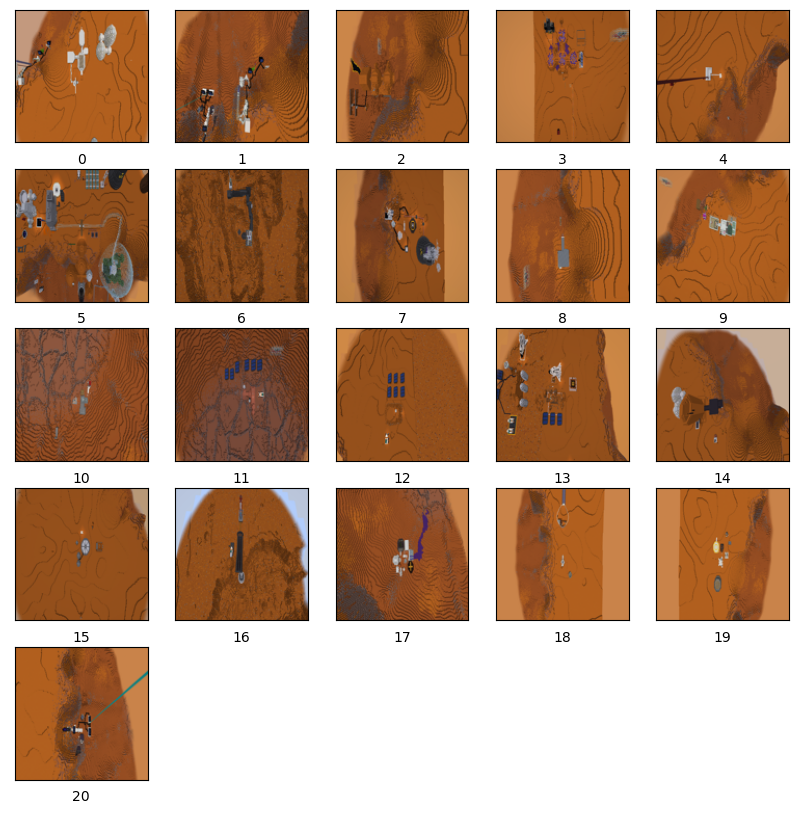

In [6]:
images = loadImages()
plt.figure(figsize=(10,10))
for i in range(len(images[0])):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[0][i])
    plt.xlabel(i)
plt.show()

In [7]:
def createModelImages(num_classes):
    inputA = Input(shape=(128,128,4))
# define our Multi-image CNN network
    x = layers.Conv2D(16, 5, activation='relu')(inputA)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 5, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(.8)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation = 'relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(.8)(x)
    x = layers.Dense(16, activation = 'relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(num_classes, activation = 'softmax')(x)
    x = Model(inputs=inputA, outputs=x)
    x.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return x

In [8]:
def createModelBlockData(num_classes):
    inputB = Input(shape=(551))
    # define MLP network for block data
    x = layers.Dense(500, activation='relu')(inputB)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(250, activation='relu')(x)
    x = layers.Dropout(.4)(x)
    x = layers.Dense(150, activation='relu', kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(x)
    x = layers.Dense(50, activation='relu')(x)
    x = layers.Dense(num_classes, activation = 'softmax')(x)
    x = Model(inputs=inputB, outputs=x)
    x.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return x
    

In [9]:
def combineModels(model_1, model_2, num_classes):
    image_model_merged = layers.Concatenate()([model_1.output, model_2.output])
    output = layers.Dense(128, activation = 'relu')(image_model_merged)
    output = layers.Flatten()(output)
    output = layers.Dense(num_classes, activation = 'softmax')(output)
    model = Model(inputs = [(model_1.input,model_2.input)],outputs = output)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return model

In [10]:
splits = 5
k_fold = model_selection.StratifiedKFold(n_splits= splits, shuffle = True, random_state = 42)
epochs=1000
results = {
    }  
for (columnName, columnData) in labels.iteritems():
    train_labels = labels[columnName].to_numpy()
    class_labels = np.unique(train_labels)
    num_classes = len(class_labels)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=train_labels)
    weight_dict = dict(zip(class_labels, class_weights))
    accuracy = []
    precision = []
    recall = []
    f1 = []
    print(columnName)
    for i, (train_indices, test_indices) in enumerate(k_fold.split(images[0], train_labels)):
        print("Split " + str(i+1))
        X_train_aerial = []
        X_train_below = []
        X_train_blocks = []
        y_train = []
        X_test_aerial = []
        X_test_below = []
        X_test_blocks = []
        y_test = []
        for index in train_indices:
            X_train_aerial.append(images[0][index])
            X_train_below.append(images[1][index])
            X_train_blocks.append(categorical.iloc[[index]].values.tolist()[0])
            y_train.append(train_labels[index])
        for index in test_indices:
            X_test_aerial.append(images[0][index])
            X_test_below.append(images[1][index])
            X_test_blocks.append(categorical.iloc[[index]].values.tolist()[0])
            y_test.append(train_labels[index])
        es = EarlyStopping(monitor='loss', mode='min', patience=3, start_from_epoch = 50,  restore_best_weights=True)
        # models
        model_aerial = createModelImages(num_classes)
        model_below = createModelImages(num_classes)
        model_blocks = createModelBlockData(num_classes)
        image_model = combineModels(model_aerial, model_below, num_classes)
        combined_model = combineModels(image_model, model_blocks, num_classes)
        X_train_1 = np.array(X_train_aerial).astype(np.float32)
        X_train_2 = np.array(X_train_below).astype(np.float32)
        X_train_3 = np.array(X_train_blocks).astype(np.float32)
        history = combined_model.fit(
        [X_train_1, X_train_2, X_train_3],
        np.array(y_train),
        class_weight = weight_dict,
        epochs=epochs,
        callbacks=[es]
        )
        X_test_1 = np.array(X_test_aerial).astype(np.float32)
        X_test_2 = np.array(X_test_below).astype(np.float32)
        X_test_3 = np.array(X_test_blocks).astype(np.float32)
        predictions = combined_model.predict([X_test_1, X_test_2, X_test_3])
        y_pred = []
        for k in range(len(predictions)):
            y_pred.append(np.argmax(predictions[k]))
        #Define scoring metrics
        accuracy.append(metrics.accuracy_score(y_test, y_pred))
        precision.append(metrics.precision_score(y_test, y_pred, average = 'macro'))
        recall.append(metrics.recall_score(y_test, y_pred, average = 'macro'))
        f1.append(metrics.f1_score(y_test, y_pred, average = 'macro')) 
    results[columnName] = {'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'f1_score':f1,
        }

oxygen_regulation


ValueError: Found input variables with inconsistent numbers of samples: [52, 64]

In [11]:
#Plot Seaborn plots to visualize results
x_label = 'Feature'
df_accuracy = pd.DataFrame(columns = [x_label, 'Accuracy'])
df_precision = pd.DataFrame(columns = [x_label, 'Precision'])
df_recall = pd.DataFrame(columns = [x_label, 'Recall'])
df_f1 = pd.DataFrame(columns = [x_label, 'F1 Score'])
for key in results:
    for metric in results[key]:
        for k in range(splits):
            if metric == 'accuracy':
                df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]}, 
                ignore_index = True)
            elif metric == 'precision':
                df_precision = df_precision.append({x_label : key, 'Precision': results[key][metric][k]}, 
                ignore_index = True)
            elif metric == 'recall':
                df_recall = df_recall.append({x_label : key, 'Recall': results[key][metric][k]}, 
                ignore_index = True)
            else:
                df_f1 = df_f1.append({x_label : key, 'F1 Score': results[key][metric][k]}, 
                ignore_index = True)
        msg = "%s: %f (%f)" % (key+" "+metric, np.mean(results[key][metric]), np.std(results[key][metric]))
        print(msg)
df_accuracy.to_csv(results_folder+"accuracy.csv", index = False)
df_precision.to_csv(results_folder+"precision.csv", index = False)
df_recall.to_csv(results_folder+"recall.csv", index = False)
df_f1.to_csv(results_folder+"f1.csv", index = False)

oxygen_regulation accuracy: 0.810000 (0.096954)
oxygen_regulation precision: 0.505000 (0.247689)
oxygen_regulation recall: 0.600000 (0.200000)
oxygen_regulation f1_score: 0.546032 (0.227067)
radiation_protection accuracy: 0.520000 (0.163095)
radiation_protection precision: 0.262222 (0.148174)
radiation_protection recall: 0.366667 (0.163299)
radiation_protection f1_score: 0.301111 (0.153253)
power_generation accuracy: 0.770000 (0.128841)
power_generation precision: 0.500000 (0.250000)
power_generation recall: 0.575000 (0.217945)
power_generation f1_score: 0.532143 (0.234847)
communications_facilities accuracy: 0.770000 (0.128841)
communications_facilities precision: 0.465000 (0.275953)
communications_facilities recall: 0.566667 (0.226078)
communications_facilities f1_score: 0.507143 (0.255950)
shape accuracy: 0.530000 (0.116619)
shape precision: 0.287778 (0.232867)
shape recall: 0.433333 (0.200000)
shape f1_score: 0.326984 (0.204618)
area accuracy: 0.530000 (0.116619)
area precision: 0.

C:\Users\humdi\AppData\Local\Temp\ipykernel_32272\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_32272\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_32272\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_accuracy = df_accuracy.append({x_label : key, 'Accuracy': results[key][metric][k]},
C:\Users\humdi\AppData\Local\Temp\ipykernel_32272\716609704.py:11: FutureWarning: The frame.append method is deprecated and will be r

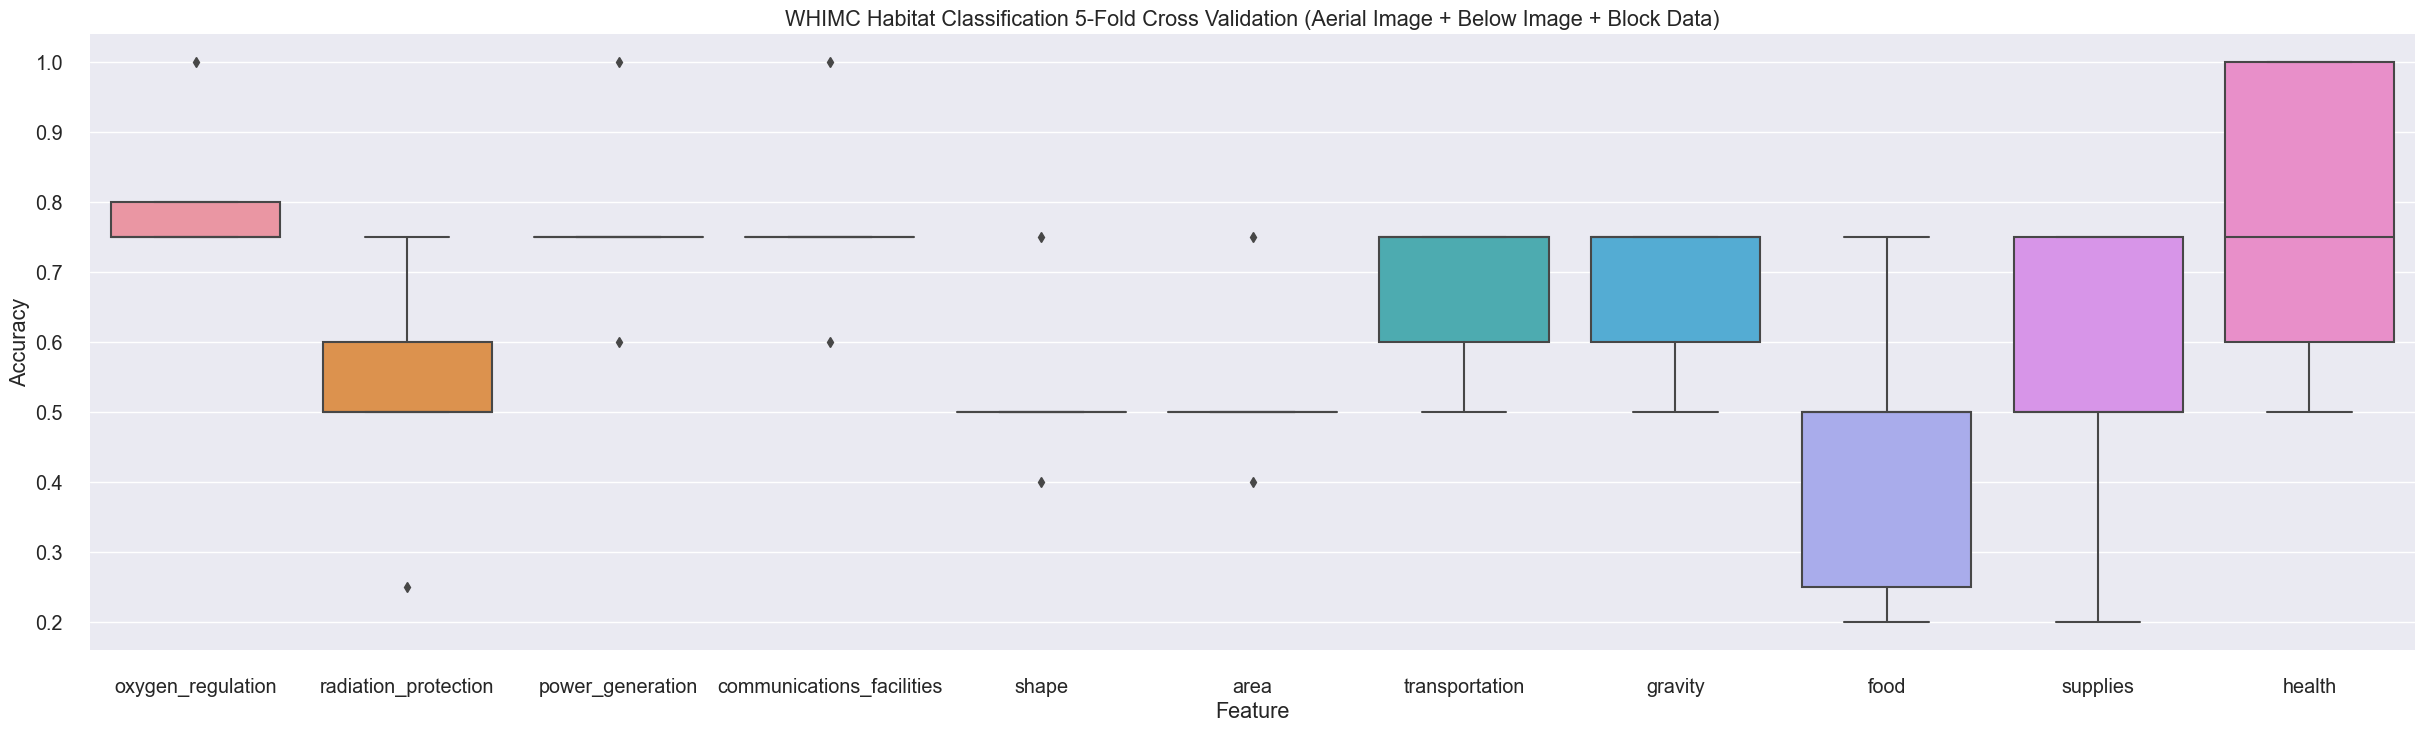

In [16]:
plt.figure()
x_label = 'Feature'
y_label = 'Accuracy'
title = 'WHIMC Habitat Classification '+str(splits)+"-Fold Cross Validation (Aerial Image + Below Image + Block Data)"
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_accuracy).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"accuracy.png")

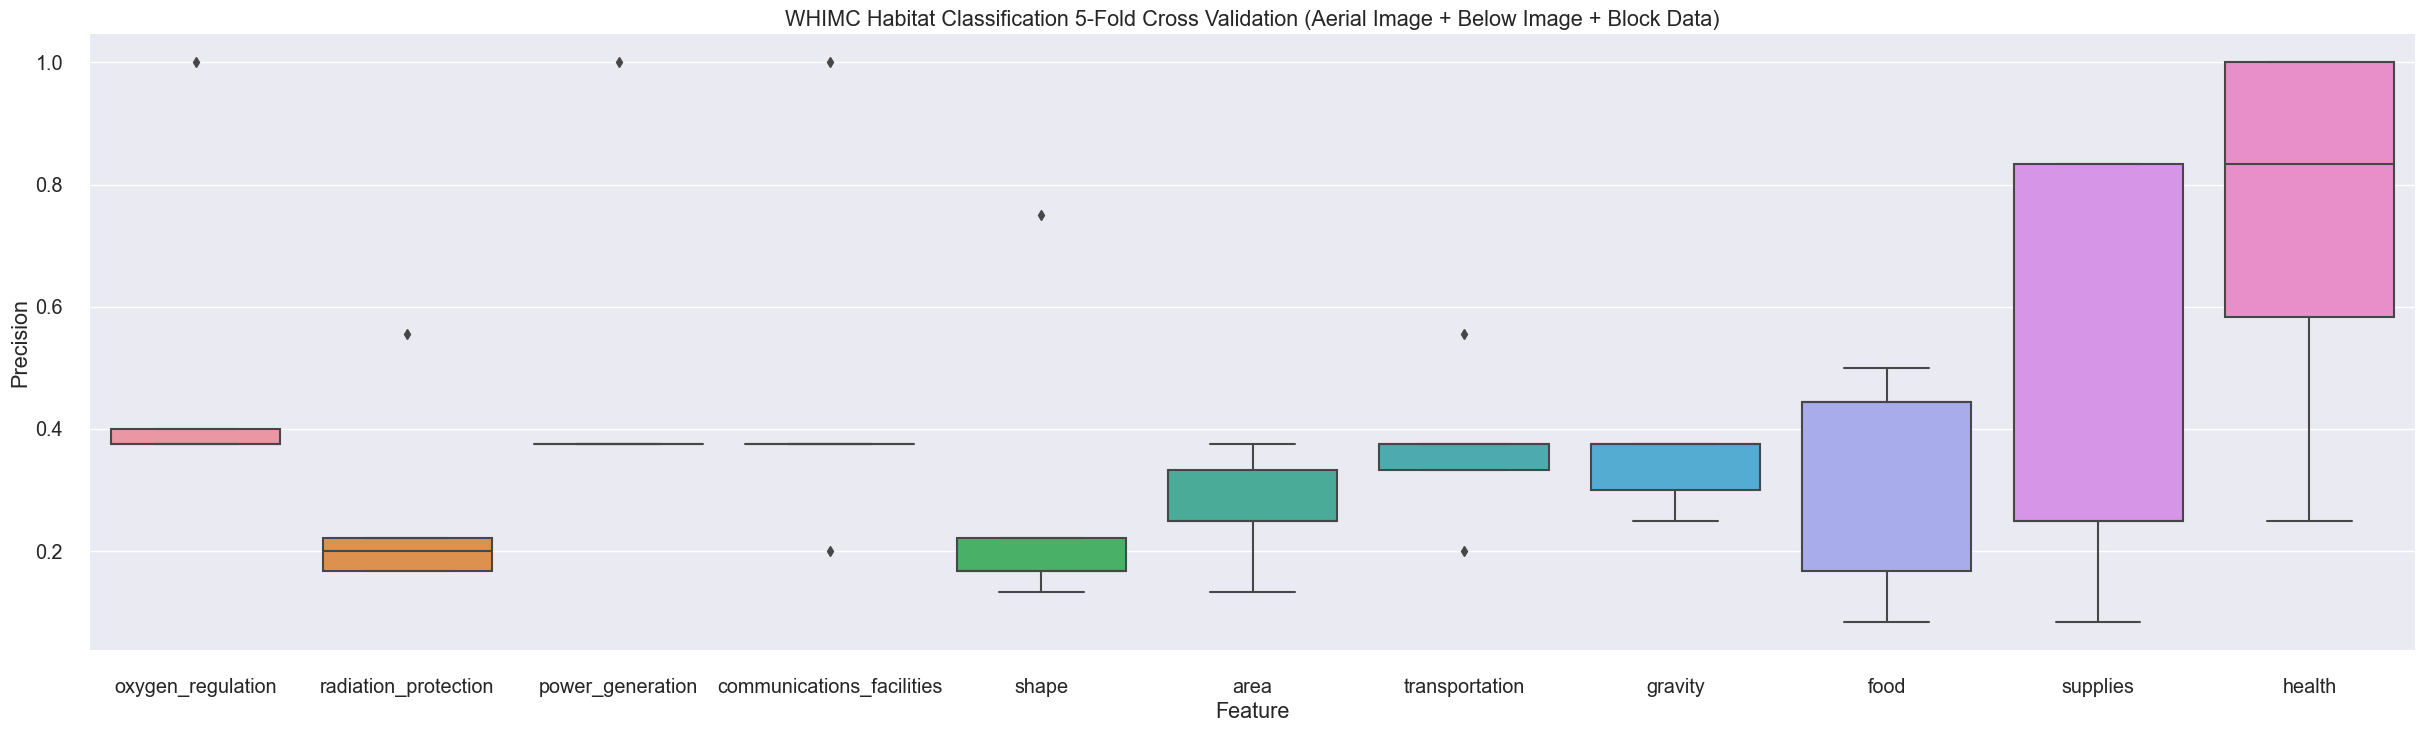

In [13]:
plt.figure()
x_label = 'Feature'
y_label = 'Precision'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_precision).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"precision.png")

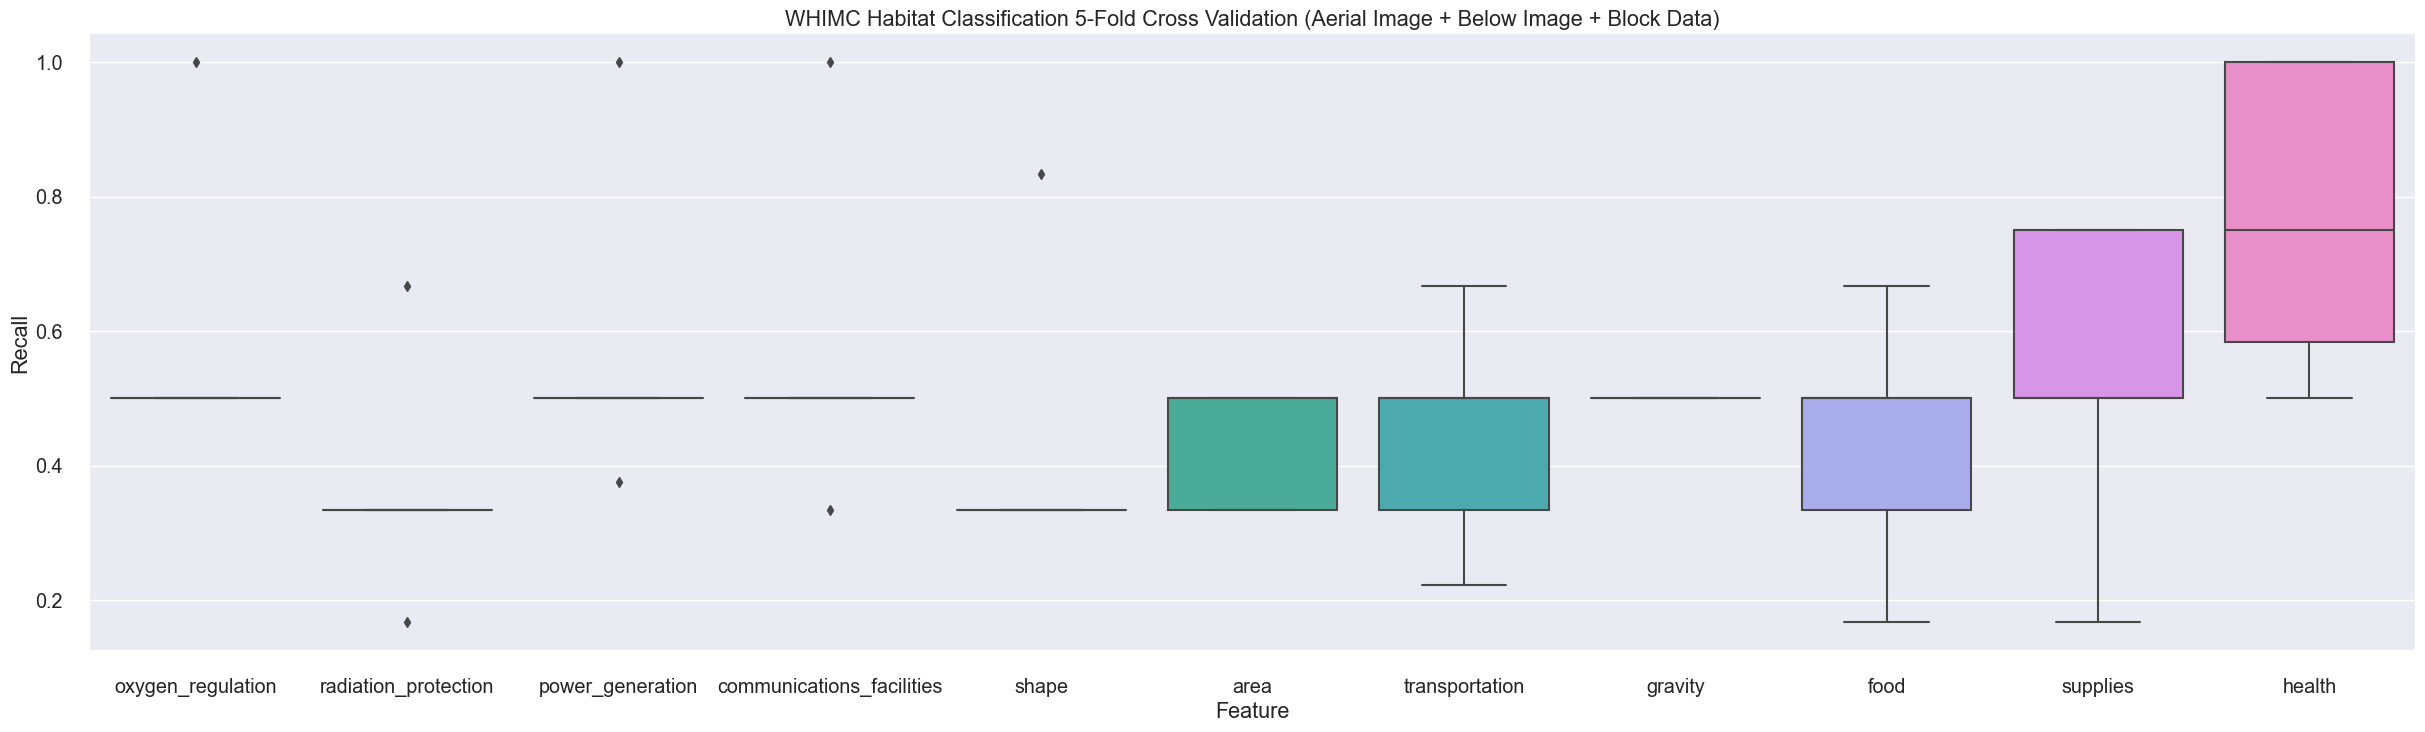

In [14]:
plt.figure()
x_label = 'Feature'
y_label = 'Recall'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_recall).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"recall.png")

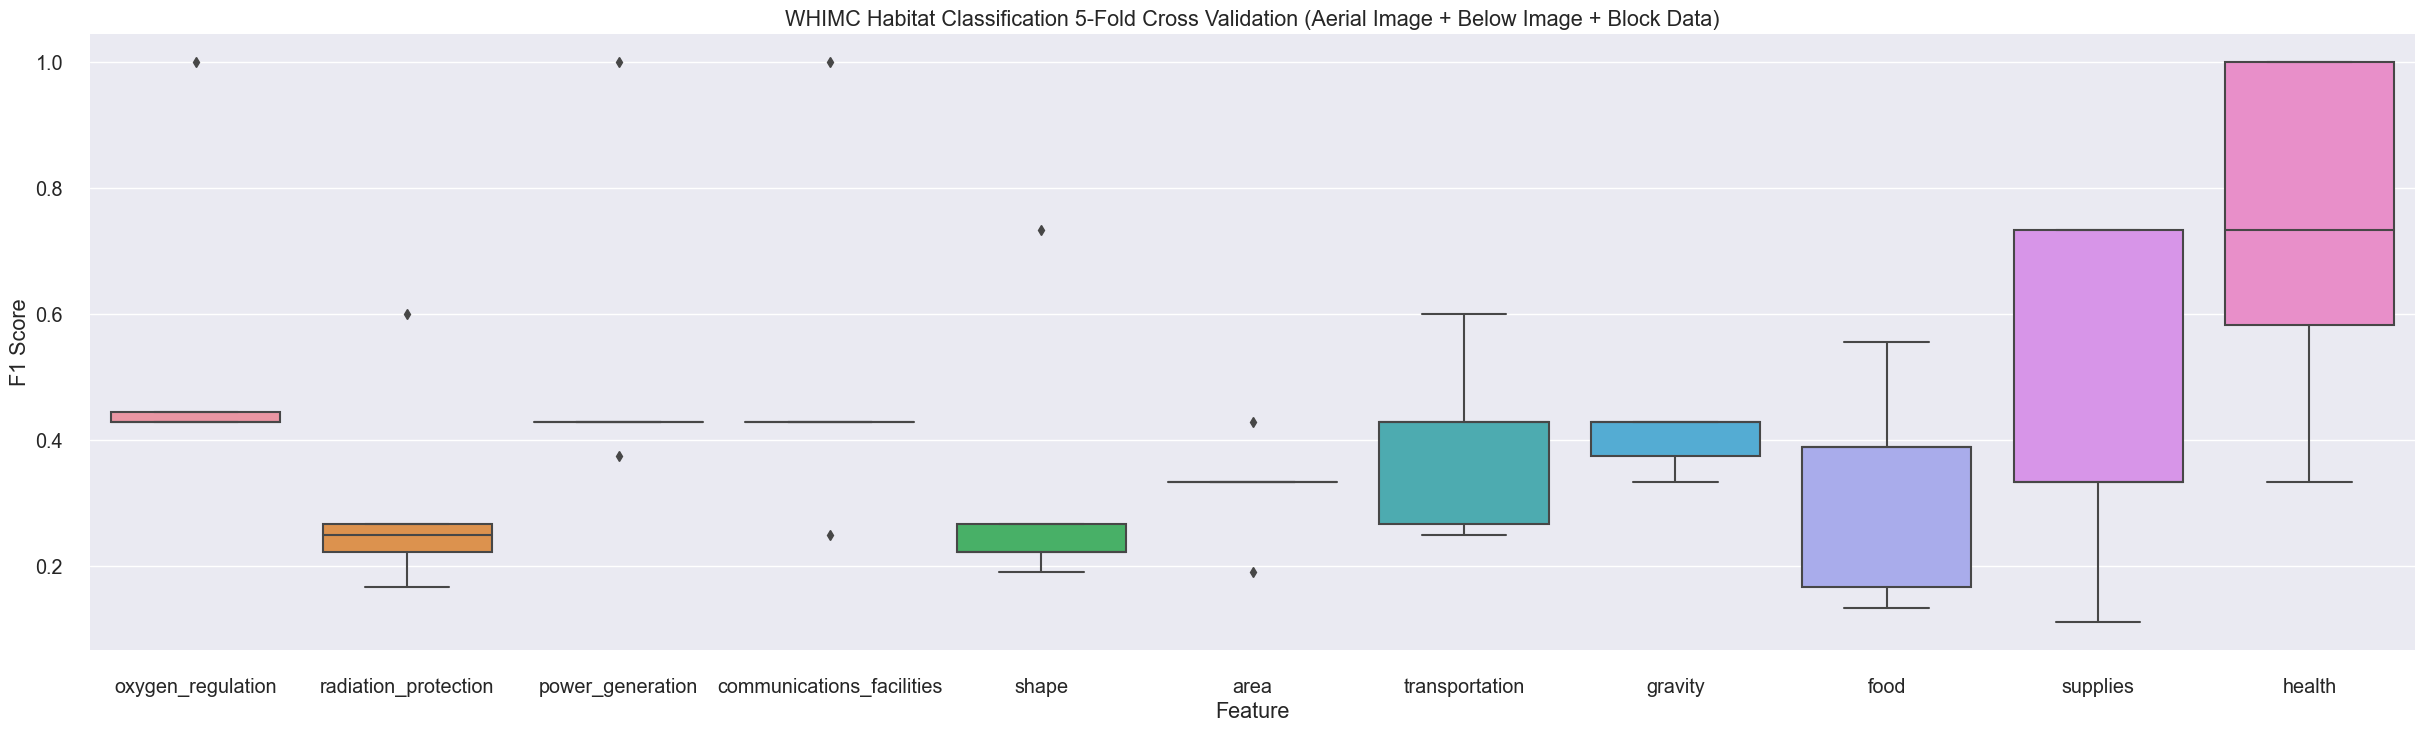

In [15]:
plt.figure()
x_label = 'Feature'
y_label = 'F1 Score'
sns.set(rc = {'figure.figsize':(30,8)})
sns.set(font_scale = 1.3)
sns.boxplot(x=x_label, y=y_label, 
            data=df_f1).set_title(title)
sns.despine(offset=10, trim=True)
plt.savefig(results_folder+"f1.png")